In [0]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# plt.rcParams["figure.figsize"] = (16, 9)
# plt.rcParams["font.size"] = 14

**Task:**  
Build a machine learning model that predicts a Wikidata item's `mid_level_categories` (multi-label) from its `claims`.


In [165]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load the data

In [0]:
PATH_TO_DATA = r"../content/drive/My Drive/Courses/Capstone/wikidata_topic_sample/"

In [0]:
ls ../content

In [0]:
train_data = pd.read_csv(PATH_TO_DATA + "train_500K_data.tsv", sep="\t")
train_data.mid_level_categories = train_data.mid_level_categories.apply(lambda x: x[2:-2].split("', '"))
train_metadata = pd.read_csv(PATH_TO_DATA + "train_500K_metadata.tsv", sep="\t")

val_data = pd.read_csv(PATH_TO_DATA + "val_50K_data.tsv", sep="\t")
val_data.mid_level_categories = val_data.mid_level_categories.apply(lambda x: x[2:-2].split("', '"))
val_metadata = pd.read_csv(PATH_TO_DATA + "val_50K_metadata.tsv", sep="\t")

test_data = pd.read_csv(PATH_TO_DATA + "test_50K_data.tsv", sep="\t")
test_data.mid_level_categories = test_data.mid_level_categories.apply(lambda x: x[2:-2].split("', '"))

In [168]:
train_data.shape, val_data.shape, test_data.shape

((500000, 3), (50000, 3), (50000, 3))

In [23]:
train_data.head(10)

,QID,claims,mid_level_categories
0,Q7804463,"[['P2048'], ['P54', 'Q213837'], ['P569'], ['P3...","[Culture.Language and literature, Culture.Sports]"
1,Q240420,"[['P646'], ['P569'], ['P1047'], ['P140', 'Q959...","[Culture.Language and literature, Culture.Phil..."
2,Q1313156,"[['P646'], ['P373'], ['P1637', 'Q2874353'], ['...","[STEM.Technology, History_And_Society.Transpor..."
3,Q22080431,"[['P17', 'Q145'], ['P118', 'Q52936104'], ['P57...",[Geography.Europe]
4,Q5616434,"[['P229'], ['P230'], ['P571'], ['P31', 'Q46970...","[STEM.Technology, History_And_Society.Transpor..."
5,Q65085319,[['<NOCLAIM>']],"[History_And_Society.Politics and government, ..."
6,Q7317656,"[['P244'], ['P101', 'Q8242'], ['P569'], ['P166...","[Culture.Language and literature, Geography.Asia]"
7,Q15637731,"[['P17', 'Q668'], ['P2003'], ['P856'], ['P571'...",[Geography.Asia]
8,Q5430543,"[['P569'], ['P650'], ['P245'], ['P570'], ['P21...","[Culture.Language and literature, Geography.Eu..."
9,Q11124749,"[['P17', 'Q148'], ['P2674', 'Q11124442'], ['P2...",[Geography.Asia]


In [24]:
train_metadata.head(10)

,QID,rev_id,talk_page_id,talk_page_title,templates
0,Q7804463,728086028,30211354,Tim Webster (American football),"['wikiproject banner shell', 'wikiproject biog..."
1,Q240420,857086388,20557789,Ermenegildo Pellegrinetti,"['wikiproject biography', 'wikiproject catholi..."
2,Q1313156,642798889,5641004,SOCATA TB family,"['wpaviation', 'wikiproject france']"
3,Q22080431,774136610,49327885,Humber Warhawks,"['wikiproject yorkshire', 'wikiproject lincoln..."
4,Q5616434,628936244,10157067,Guine Bissau Airlines,['wpaviation']
5,Q65085319,889300783,60308004,1972 Kansas gubernatorial election,"['wikiproject elections and referendums', 'wik..."
6,Q7317656,796513164,27222360,Reuven Tsur,"['wikiproject biography', 'wp israel']"
7,Q15637731,814659414,52081272,National Institute of Tourism and Hospitality ...,['wikiproject india']
8,Q5430543,706088500,10577547,Fairlie Harmar,"['wikiproject banner shell', 'wikiproject biog..."
9,Q11124749,846077152,25608106,Second Wuhan Yangtze River Bridge,"['wikiproject banner shell', 'wikiproject brid..."


In [25]:
# num of unique categories
categories_set = set()
for label_list in train_data.mid_level_categories:
    categories_set = categories_set.union(set(label_list))
print(f"Num of categories: {len(categories_set)}")

Num of categories: 45


In [0]:
# decode str of claims

# def decode_raw_claims_to_list(claims):
#     claims_list_raw = claims[1:-1].split(", ")
#     print(claims_list_raw)
#     claims_list = []
#     for item in claims_list_raw:
#         if item[0] == "[" and item[-1] == "]":
#             claims_list.append([item[2:-2]])
#         elif item[0] == "[":
#             claims_list.append([item[2:-1]])
#         elif item[-1] == "]":
#             claims_list[-1].append(item[1:-2])
#         else:
#             claims_list[-1].append(item[1:-1])
#     return claims_list

def decode_raw_claims_to_dict(claims):
    claims_list_raw = claims[2:-2].split("], [")
    claims_dict = {}
    for item in claims_list_raw:
        split_list = item[1:-1].split("', '")
        if len(split_list) == 2:
            claims_dict[split_list[0]] = split_list[1]
        elif len(split_list) == 1:
            claims_dict[split_list[0]] = 1
        else:
            raise Exception
    return claims_dict

In [0]:
train_data["claims_dict"] = train_data.claims.apply(decode_raw_claims_to_dict)
val_data["claims_dict"] = val_data.claims.apply(decode_raw_claims_to_dict)
test_data["claims_dict"] = test_data.claims.apply(decode_raw_claims_to_dict)

In [28]:
# num of unique claims
from collections import Counter
claims_counter = Counter()
for claims_dict in train_data.claims_dict:
    claims_counter.update(claims_dict.keys())
    
print(f"Num of unique claim-keys: {len(claims_counter)}")

Num of unique claim-keys: 5021


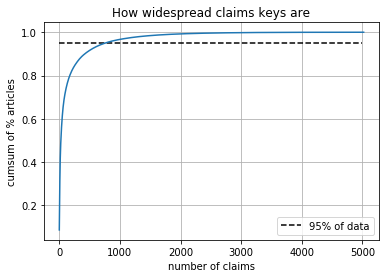

In [29]:
counts = [y for (x, y) in claims_counter.most_common()]
counts = np.array(counts)
plt.plot(counts.cumsum() / counts.sum())
plt.hlines(0.95, 0, 5000, linestyles='--', label="95% of data")
plt.xlabel("number of claims")
plt.ylabel("cumsum of % articles")
plt.title("How widespread claims keys are")
plt.legend()
plt.grid()

So it's ok to take only 1000 most common claims, we'll capture more than 95%.  
Let's take 100 for the start.

## Create data table for the model

In [0]:
top_k = 100
selected_claims = {name for name, _ in claims_counter.most_common()[:top_k]}

In [0]:
def filter_claim_keys(claims_dict, selected_claims=selected_claims):
    return {key: value
            for key, value in claims_dict.items()
            if key in selected_claims}

train_data["claims_dict_top_k"] = train_data.claims_dict.apply(filter_claim_keys)
val_data["claims_dict_top_k"] = val_data.claims_dict.apply(filter_claim_keys)
test_data["claims_dict_top_k"] = test_data.claims_dict.apply(filter_claim_keys)

In [32]:
train_data.head()

,QID,claims,mid_level_categories,claims_dict,claims_dict_top_k
0,Q7804463,"[['P2048'], ['P54', 'Q213837'], ['P569'], ['P3...","[Culture.Language and literature, Culture.Sports]","{'P2048': 1, 'P54': 'Q213837', 'P569': 1, 'P35...","{'P2048': 1, 'P54': 'Q213837', 'P569': 1, 'P10..."
1,Q240420,"[['P646'], ['P569'], ['P1047'], ['P140', 'Q959...","[Culture.Language and literature, Culture.Phil...","{'P646': 1, 'P569': 1, 'P1047': 1, 'P140': 'Q9...","{'P646': 1, 'P569': 1, 'P140': 'Q9592', 'P570'..."
2,Q1313156,"[['P646'], ['P373'], ['P1637', 'Q2874353'], ['...","[STEM.Technology, History_And_Society.Transpor...","{'P646': 1, 'P373': 1, 'P1637': 'Q2874353', 'P...","{'P646': 1, 'P373': 1, 'P279': 'Q20026838', 'P..."
3,Q22080431,"[['P17', 'Q145'], ['P118', 'Q52936104'], ['P57...",[Geography.Europe],"{'P17': 'Q145', 'P118': 'Q52936104', 'P571': 1...","{'P17': 'Q145', 'P571': 1, 'P31': 'Q17156793',..."
4,Q5616434,"[['P229'], ['P230'], ['P571'], ['P31', 'Q46970...","[STEM.Technology, History_And_Society.Transpor...","{'P229': 1, 'P230': 1, 'P571': 1, 'P31': 'Q469...","{'P571': 1, 'P31': 'Q46970', 'P17': 'Q1007'}"


In [33]:
## Check
claims_counter = Counter()
for claims_dict in train_data.claims_dict_top_k:
    claims_counter.update(claims_dict.keys())
    
print(f"Num of unique claim-keys: {len(claims_counter)}")

Num of unique claim-keys: 100


In [0]:
X_train = pd.DataFrame(list(train_data.claims_dict_top_k))
X_val = pd.DataFrame(list(val_data.claims_dict_top_k))
X_test = pd.DataFrame(list(val_data.claims_dict_top_k))
# df_train.fillna(0, inplace=True)

In [172]:
X_test.shape

(50000, 100)

In [35]:
X_train.head(10)

,<NOCLAIM>,P1006,P102,P105,P106,P108,P1082,P1303,P131,P1343,P1344,P136,P140,P1412,P1417,P1435,P1447,P1448,P1476,P1532,P155,P1559,P156,P1566,P159,P161,P166,P17,P171,P175,P18,P1889,P19,P1953,P20,P2002,P2044,P2046,P2048,P2067,...,P345,P360,P361,P364,P373,P39,P407,P413,P421,P434,P462,P463,P47,P473,P495,P5055,P54,P569,P57,P570,P571,P577,P585,P590,P625,P641,P646,P648,P685,P69,P691,P734,P735,P815,P830,P846,P856,P910,P937,P94
0,NaN,NaN,NaN,NaN,Q19204627,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Q2278965,NaN,NaN,NaN,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Q213837,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Q41323,NaN,NaN,NaN,Q5611394,NaN,Q21484845,Q1369663,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,NaN,NaN,Q250867,NaN,NaN,NaN,NaN,NaN,Q1376234,NaN,Q9592,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,Q216853,NaN,Q220,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,Q50362553,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,Q246887,NaN,NaN,Q1355877,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Q145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Q41323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Q1007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,1.0,NaN,NaN,Q15962340,Q319239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Q9288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Q616568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Q174158,NaN,NaN,Q1112068,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Q1361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Q668,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,Q1028181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Q1399299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Q148,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [173]:
# binarize the labels
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(train_data.mid_level_categories)
y_val = mlb.transform(val_data.mid_level_categories)
y_test = mlb.transform(test_data.mid_level_categories)
list(mlb.classes_)

['',
 'Culture.Arts',
 'Culture.Broadcasting',
 'Culture.Crafts and hobbies',
 'Culture.Entertainment',
 'Culture.Food and drink',
 'Culture.Games and toys',
 'Culture.Internet culture',
 'Culture.Language and literature',
 'Culture.Media',
 'Culture.Music',
 'Culture.Performing arts',
 'Culture.Philosophy and religion',
 'Culture.Plastic arts',
 'Culture.Sports',
 'Culture.Visual arts',
 'Geography.Africa',
 'Geography.Americas',
 'Geography.Antarctica',
 'Geography.Asia',
 'Geography.Bodies of water',
 'Geography.Europe',
 'Geography.Landforms',
 'Geography.Maps',
 'Geography.Oceania',
 'Geography.Parks',
 'History_And_Society.Business and economics',
 'History_And_Society.Education',
 'History_And_Society.History and society',
 'History_And_Society.Military and warfare',
 'History_And_Society.Politics and government',
 'History_And_Society.Transportation',
 'STEM.Biology',
 'STEM.Chemistry',
 'STEM.Engineering',
 'STEM.Geosciences',
 'STEM.Information science',
 'STEM.Mathematics',


In [37]:
y_train.shape, y_val.shape

((500000, 45), (50000, 45))

In [0]:
label_columns = []

df_train = X_train.copy()
for i in range(y_train.shape[1]):
    column_name = f"y_{i}"
    df_train[column_name] = y_train[:, i]
    label_columns.append(column_name)

df_val = X_val.copy()
for i in range(y_val.shape[1]):
    column_name = f"y_{i}"
    df_val[column_name] = y_val[:, i]

In [0]:
df = pd.concat([df_train, df_val], ignore_index=True, sort=False)

In [0]:
for col in X_train.columns:
    df[col] = df[col].apply(str)

In [41]:
df.head()

,<NOCLAIM>,P1006,P102,P105,P106,P108,P1082,P1303,P131,P1343,P1344,P136,P140,P1412,P1417,P1435,P1447,P1448,P1476,P1532,P155,P1559,P156,P1566,P159,P161,P166,P17,P171,P175,P18,P1889,P19,P1953,P20,P2002,P2044,P2046,P2048,P2067,...,y_5,y_6,y_7,y_8,y_9,y_10,y_11,y_12,y_13,y_14,y_15,y_16,y_17,y_18,y_19,y_20,y_21,y_22,y_23,y_24,y_25,y_26,y_27,y_28,y_29,y_30,y_31,y_32,y_33,y_34,y_35,y_36,y_37,y_38,y_39,y_40,y_41,y_42,y_43,y_44
0,nan,nan,nan,nan,Q19204627,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,Q2278965,nan,nan,nan,nan,nan,1.0,1.0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,nan,1.0,nan,nan,Q250867,nan,nan,nan,nan,nan,Q1376234,nan,Q9592,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.0,nan,Q216853,nan,Q220,nan,nan,nan,nan,nan,...,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
3,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,Q145,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,Q1007,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [0]:
import pandas as pd

In [0]:
df.to_parquet(PATH_TO_DATA + "df_100_claims.parquet")

In [44]:

mlb.classes_

array(['', 'Culture.Arts', 'Culture.Broadcasting',
       'Culture.Crafts and hobbies', 'Culture.Entertainment',
       'Culture.Food and drink', 'Culture.Games and toys',
       'Culture.Internet culture', 'Culture.Language and literature',
       'Culture.Media', 'Culture.Music', 'Culture.Performing arts',
       'Culture.Philosophy and religion', 'Culture.Plastic arts',
       'Culture.Sports', 'Culture.Visual arts', 'Geography.Africa',
       'Geography.Americas', 'Geography.Antarctica', 'Geography.Asia',
       'Geography.Bodies of water', 'Geography.Europe',
       'Geography.Landforms', 'Geography.Maps', 'Geography.Oceania',
       'Geography.Parks', 'History_And_Society.Business and economics',
       'History_And_Society.Education',
       'History_And_Society.History and society',
       'History_And_Society.Military and warfare',
       'History_And_Society.Politics and government',
       'History_And_Society.Transportation', 'STEM.Biology',
       'STEM.Chemistry', 'STEM.E

In [0]:
# import pickle

# # to save classes list
# with open(PATH_TO_DATA + 'classes_list', 'wb') as fp:
#     pickle.dump(mlb.classes_, fp)
    
# # To read it back:
# with open (PATH_TO_DATA + 'classes_list', 'rb') as fp:
#     classes_list = pickle.load(fp)

## Model. Fastai

In [0]:
from fastai.tabular import * 

In [0]:
valid_idx = range(X_train.shape[0], len(df))
procs = [FillMissing, Categorify, Normalize]
# specify labels column, categorical columns (in our case all are categorical)
dep_var_list = label_columns
cat_names = list(X_train.columns)

In [0]:
OptTabTfms = Optional[Collection[TabularProc]]

In [0]:
class TabularDataBunch_v2(DataBunch):
    "Create a `DataBunch` suitable for tabular data."
    @classmethod
    def from_df(cls, path, df:DataFrame, dep_var_list:list, valid_idx:Collection[int], procs:OptTabTfms=None,
                cat_names:OptStrList=None, cont_names:OptStrList=None, classes:Collection=None, 
                test_df=None, bs:int=64, val_bs:int=None, num_workers:int=defaults.cpus, dl_tfms:Optional[Collection[Callable]]=None, 
                device:torch.device=None, collate_fn:Callable=data_collate, no_check:bool=False)->DataBunch:
        "Create a `DataBunch` from `df` and `valid_idx` with `dep_var`. `kwargs` are passed to `DataBunch.create`."
        cat_names = ifnone(cat_names, []).copy()
        cont_names = ifnone(cont_names, list(set(df)-set(cat_names)-set(dep_var_list)))
        procs = listify(procs)
        src = (TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(valid_idx))
        src = src.label_from_df(dep_var_list)
        
        if test_df is not None:
#             raise NotImplementedError("label from df should be changed most probably, CHECK!!!")
            src.add_test(TabularList.from_df(test_df, cat_names=cat_names, cont_names=cont_names,
                                             processor = src.train.x.processor))
            
        return src.databunch(path=path, bs=bs, val_bs=val_bs,
                             num_workers=num_workers, device=device, 
                             collate_fn=collate_fn, no_check=no_check)

In [0]:
data = TabularDataBunch_v2.from_df("", df, dep_var_list, valid_idx=valid_idx, procs=procs, cat_names=cat_names, 
                                   bs=32, test_df=X_test)

In [176]:
data.test_ds

LabelList (50000 items)
x: TabularList
<NOCLAIM> #na#; P1006 #na#; P102 #na#; P105 #na#; P106 Q483501; P108 #na#; P1082 #na#; P1303 #na#; P131 #na#; P1343 #na#; P1344 #na#; P136 #na#; P140 #na#; P1412 #na#; P1417 #na#; P1435 #na#; P1447 #na#; P1448 #na#; P1476 #na#; P1532 #na#; P155 #na#; P1559 #na#; P156 #na#; P1566 #na#; P159 #na#; P161 #na#; P166 #na#; P17 #na#; P171 #na#; P175 #na#; P18 #na#; P1889 #na#; P19 #na#; P1953 #na#; P20 #na#; P2002 #na#; P2044 #na#; P2046 #na#; P2048 #na#; P2067 #na#; P21 Q6581097; P213 #na#; P214 #na#; P2163 #na#; P225 #na#; P227 #na#; P242 #na#; P244 #na#; P2446 #na#; P2603 #na#; P264 #na#; P268 #na#; P269 #na#; P27 Q16; P279 #na#; P281 #na#; P31 Q5; P3151 #na#; P3417 #na#; P3430 #na#; P345 #na#; P360 #na#; P361 #na#; P364 #na#; P373 #na#; P39 #na#; P407 #na#; P413 #na#; P421 #na#; P434 #na#; P462 #na#; P463 #na#; P47 #na#; P473 #na#; P495 #na#; P5055 #na#; P54 #na#; P569 #na#; P57 #na#; P570 #na#; P571 #na#; P577 #na#; P585 #na#; P590 #na#; P625 #na#; 

In [50]:
(cat_x,cont_x),y = next(iter(data.train_dl))
for o in (cat_x, cont_x, y): print(to_np(o[:5]))

[[    2     2  1964    44 ...     1 30333   568     1]
 [    1     2  1964    44 ...     2 34677   568     2]
 [    1     2  1964    44 ...     2 34677   568     2]
 [    2     2  1964    44 ...     2 34677   568     2]
 [    2     2  1964    44 ...     2 34677   568     2]]
[0 0 0 0 0]
[[0. 0. 0. 0. ... 0. 0. 0. 0.]
 [0. 0. 0. 0. ... 0. 0. 0. 0.]
 [0. 0. 0. 0. ... 0. 0. 0. 0.]
 [0. 0. 1. 0. ... 0. 0. 0. 0.]
 [0. 0. 0. 0. ... 0. 0. 0. 0.]]


In [0]:
import fastai.tabular.data as tabular_data

tabular_data.emb_sz_rule = lambda n_cat : min(4, round(1.6 * n_cat**0.56))

layer_sizes = [100] #[200, 100]
learn = tabular_learner(data, layers=layer_sizes, metrics=accuracy_thresh)
# change last layer dim
learn.model.layers[-1] = nn.Linear(layer_sizes[-1], len(dep_var_list))

In [0]:
print(learn.loss_func)

FlattenedLoss of BCEWithLogitsLoss()


In [0]:
learn.model

In [0]:
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.058103,0.062576,0.982843,29:58
1,0.054403,0.055456,0.983861,50:01
2,0.051558,0.053206,0.984355,37:28


In [0]:
# ! mkdir models
# ! mv model_v1.pth models/

In [0]:
# # save the model
# learn.save("model_v1")

# # load the model. Should be in foldef "models/"
learn.load(file="model_v1")

In [0]:
# df.replace("nan", np.nan, inplace=True)

In [94]:
# get preds and labels for validation
preds_valid = learn.get_preds(ds_type=DatasetType.Valid)
preds_valid[0].shape

torch.Size([50000, 45])

In [107]:
pred_label_val_2nc = torch.stack(preds_valid)
pred_label_val_2nc = torch.where(pred_label_val_2nc>0.5, torch.tensor(1), torch.tensor(0))
pred_label_val_2nc.shape

torch.Size([2, 50000, 45])

In [198]:
# get preds and labels for test
preds_test = learn.get_preds(ds_type=DatasetType.Test)
preds_test[1] = torch.tensor(y_test).float()
pred_label_test_2nc = torch.stack(preds_test)
pred_label_test_2nc = torch.where(pred_label_test_2nc>0.5, torch.tensor(1), torch.tensor(0))
pred_label_test_2nc.shape

torch.Size([2, 50000, 45])

In [0]:
VALID_TYPES = {"micro", "macro"}

def precision(pred_label_2nc, typ="micro"):
    if typ not in VALID_TYPES:
        raise ValueError("typ must be one of %r." % VALID_TYPES)
    tp_c = (pred_label_2nc[0, ...] == pred_label_2nc[1, ...]).sum(axis=0).float()
    fp_c = (pred_label_2nc[0, ...] - pred_label_2nc[1, ...] == 1).sum(axis=0).float()
    if typ == "macro":
        return float((tp_c / (tp_c + fp_c)).mean())
    elif typ == "micro":
        return float(tp_c.sum() / (tp_c.sum() + fp_c.sum()))
    
def recall(pred_label_2nc, typ="micro"):
    if typ not in VALID_TYPES:
        raise ValueError("typ must be one of %r." % VALID_TYPES)
    tp_c = (pred_label_2nc[0, ...] == pred_label_2nc[1, ...]).sum(axis=0).float()
    fn_c = (pred_label_2nc[0, ...] - pred_label_2nc[1, ...] == -1).sum(axis=0).float()
    if typ == "macro":
        return float((tp_c / (tp_c + fn_c)).mean())
    elif typ == "micro":
        return float(tp_c.sum() / (tp_c.sum() + fn_c.sum()))

In [203]:
def print_scores(pred_label_2nc):
    pr_macro = precision(pred_label_2nc, "macro")
    pr_micro = precision(pred_label_2nc, "micro")
    rec_macro = recall(pred_label_2nc, "macro")
    rec_micro = recall(pred_label_2nc, "micro")
    print("Macro precision: %.3f" % pr_macro)
    print("Micro precision: %.3f" % pr_micro)
    print("Macro recall: %.3f" % rec_macro)
    print("Micro recall: %.3f" % rec_micro)
    print("Macro F1 score: %.3f" % (2 * pr_macro * rec_macro / (pr_macro + rec_macro)))
    print("Micro F1 score: %.3f" % (2 * pr_micro * rec_micro / (pr_micro + rec_micro)))

print("Validation")
print_scores(pred_label_val_2nc)
print("\nTest")
print_scores(pred_label_test_2nc)

Validation
Macro precision: 0.978
Micro precision: 0.978
Macro recall: 0.963
Micro recall: 0.962
Macro F1 score: 0.971
Micro F1 score: 0.970

Test
Macro precision: 0.976
Micro precision: 0.979
Macro recall: 0.964
Micro recall: 0.967
Macro F1 score: 0.970
Micro F1 score: 0.973


In [0]:
# # row prediction
# learn.predict(df[cat_names].iloc[3])

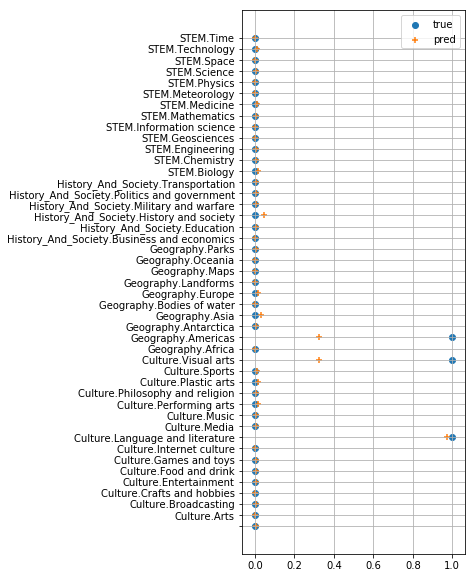

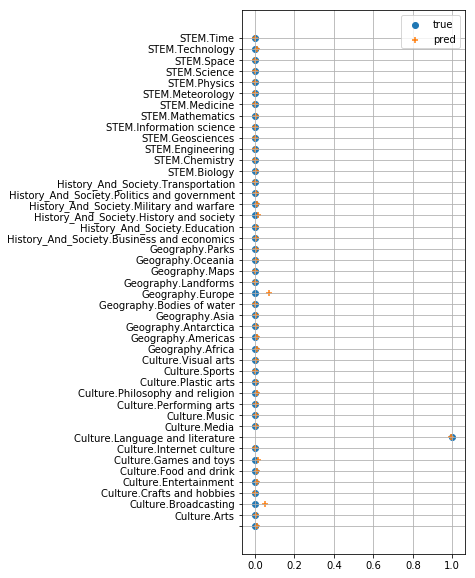

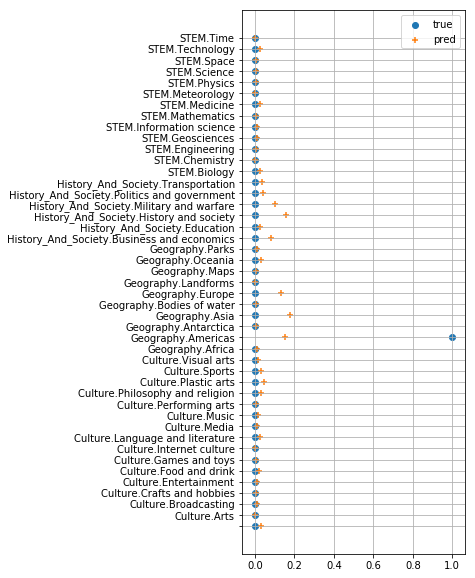

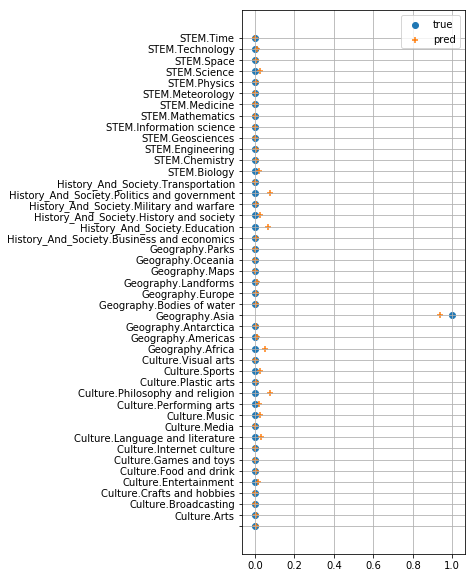

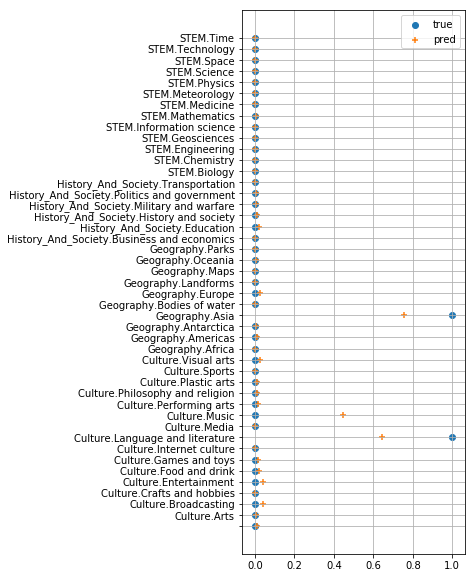

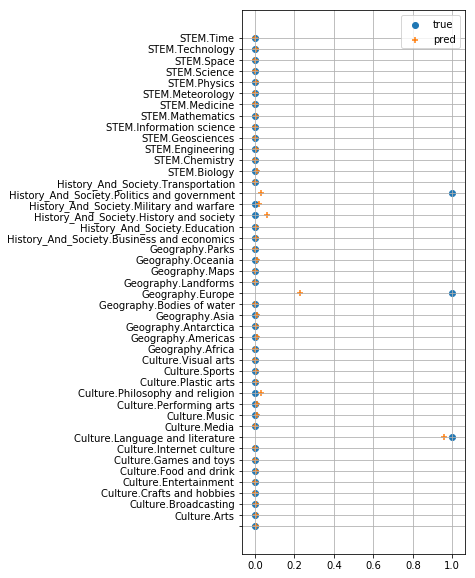

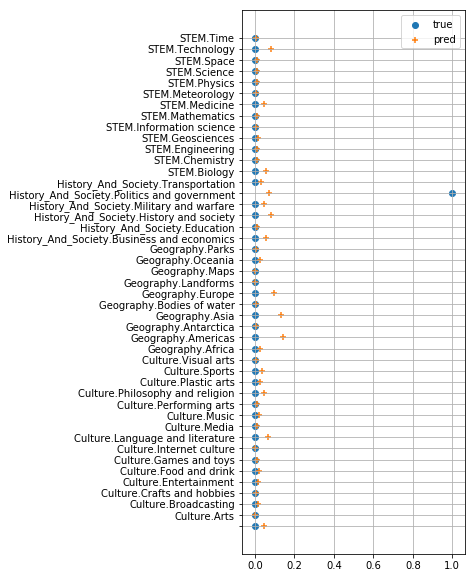

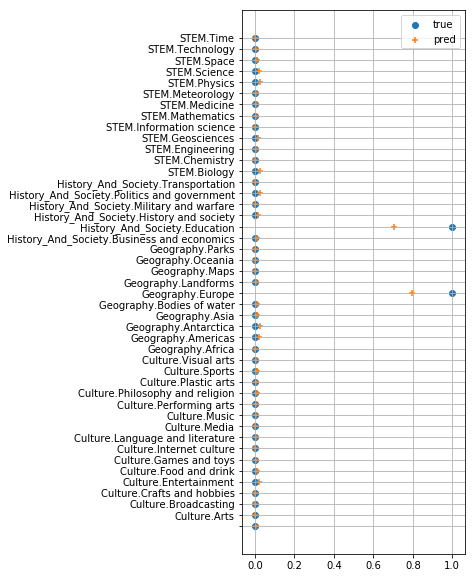

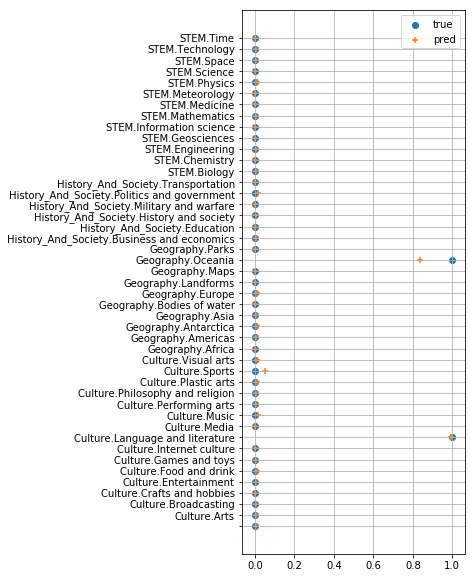

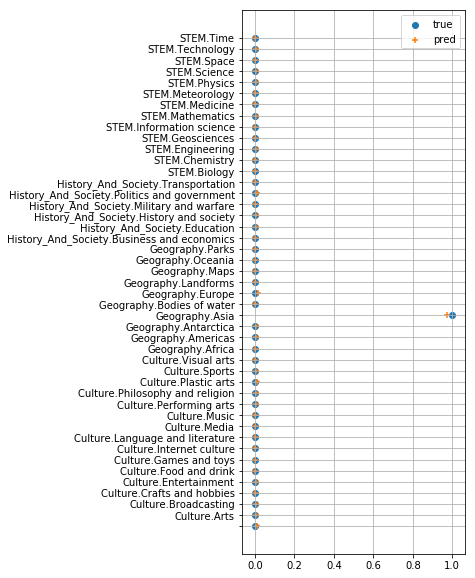

In [0]:
for idx in range(500000, 500010):
    probs = learn.predict(df.iloc[idx])[-1]
    ys = range(1, len(label_columns)+1)
    plt.figure(figsize=(4,10))
    plt.scatter(df.iloc[idx][label_columns], ys, label="true")
    plt.scatter(probs, ys, label="pred", marker='+')
    plt.yticks(ys, list(mlb.classes_))
    plt.legend()
    plt.grid()
    plt.show()